## Artificial Intelligence - Computer Assignment 05: Convolutional Neural Network

## Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [2]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import warnings

warnings.filterwarnings("ignore")

## Model training config

In [4]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15
SEQUENCE_LEN = 64
CNN_FILTERS = 64

# Part 0: Data Preparation

## Load Data

In [ ]:
from google.colab import files

uploaded = files.upload()

In [7]:
import io

df = pd.read_csv(io.BytesIO(uploaded['twitter-suicidal-data.csv']))
print(df.head(10))

                                               tweet  intention
0  my life is meaningless i just want to end my l...          1
1  muttering i wanna die to myself daily for a fe...          1
2  work slave i really feel like my only purpose ...          1
3  i did something on the 2 of october i overdose...          1
4  i feel like no one cares i just want to die ma...          1
5  i am great and wonderful i am worth it except ...          1
6  i ll be dead just you wait and see my last wor...          1
7  health anxiety prompting some bad thoughts in ...          1
8  everything is okay but nothing feels okay i ve...          1
9  ptsd and alcohol i had some extremely horrible...          1


## Data Preprocessing

In [ ]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger", "words"])

In [39]:
import string

stop_words = nltk.corpus.stopwords.words("english")
for i in range(len(stop_words)):
    stop_words[i] = re.sub(r"'", "", stop_words[i])
words = set(nltk.corpus.words.words())
lemmatizer = nltk.stem.WordNetLemmatizer()

def convert_emoji_to_text(text):
    return emoji.replace_emoji(text, replace='')

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    # lowercasing the text
    text = text.lower()

    # removing usernames
    text = re.sub(r'@\S+', '', text)

    # removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # removing numbers
    text = text.translate(str.maketrans('', '', string.digits))

    # removing urls
    text = re.sub(r'https?\S+|www\S+', '', text)

    # converting emojis to text
    text = convert_emoji_to_text(text)

    # removing extra spaces
    text = " ".join(text.split())

    # removing non-word characters
    # text = " ".join(word for word in text.split() if word in words)

    # lemmatization and tokenization of the text
    word_tokens = text.split()
    # word_tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(word_tokens)
    tokens = []
    for i in range(len(word_tokens)):
        token = lemmatizer.lemmatize(word_tokens[i], nltk_pos_tagger(pos_tags[i][1]))
        if len(token) > 1:
            tokens.append(token)

    # removing stopwords
    final_tokens = []
    for word in tokens:
        if word not in stop_words:
            final_tokens.append(word)

    # return tokens
    return final_tokens

### Apply the implemented function on some arbitrary samples of the given dataset and display and compare the tweet text before and after preprocessing.


In [40]:
# Showing some samples before/after preprocessing
for i in range(0, len(df), 500):
    print(f"Tweet Number[{i + 1}]")
    print("Before Preprocessing:")
    print(df.iloc[i, 0])
    print("After Preprocessing:")
    print(preprocess_data(df.iloc[i, 0]), '\n')

Tweet Number[1]
Before Preprocessing:
my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
After Preprocessing:
['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'want', 'create', 'meaning', 'create', 'meaning', 'pain', 'long', 'hold', 'back', 'urge', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposite', 'way', 'stop', 'feel', 'jealous', 'tragic', 'character', 'like', 'gomer', 'pile', 'swift', 'end', 'able', 'bring', 'life'] 

Tweet Number[501]
Before Preprocessing:
why i want to just end everything in no particular order i am short i am unattractive i have social anxiety i cant make friends i have nev

### Briefly explain about the advantages and disadvantages of converting the text to lowercase format and tell why we do this processing?

**Advantages of Converting Text to Lowercase**<br>
1. `Consistency`: It ensures that words like "Apple" and "apple" are treated as the same word, reducing the complexity of the vocabulary and making text processing more consistent.
2. `Simplification`: Simplifies text processing tasks by reducing the number of distinct tokens. This is especially useful in tasks like text classification and information retrieval where variations in case do not carry significant meaning.
3. `Improved Matching`: Facilitates better matching of words in tasks such as search engines, where case differences should not affect the results.

**Disadvantages of Converting Text to Lowercase**<br>
1. `Loss of Information`: Case may carry important information in some contexts. For example, "US" (United States) and "us" (pronoun) are distinct terms whose meanings are lost if converted to lowercase.
2. `Named Entities`: Proper nouns, acronyms, and other named entities can lose their distinctiveness when lowercased, potentially impacting tasks like named entity recognition (NER).
3. `Readability`: Converting text to lowercase can reduce readability, making it harder to distinguish sentence beginnings, proper nouns, and acronyms.

**Why Do We Perform This Processing?**<br>
Lowercasing is typically performed to standardize the text data and ensure uniformity, which is crucial for many NLP tasks. It is often done as part of preprocessing for the following reasons:
- `Preprocessing Step`: It is a simple and effective preprocessing step that can help reduce the noise in text data.
- `Model Efficiency`: Helps in making the models more efficient by reducing the vocabulary size, leading to faster and more efficient training.

### Search about removing numbers in the above processes and name some advantages and disadvantages of this process.

Removing numbers from text during preprocessing in NLP tasks has its own set of advantages and disadvantages. Understanding these can help determine when and why to apply this technique based on the specific requirements of our NLP project.

**Advantages of Removing Numbers**<br>
1. `Noise Reduction`: Removing numbers can help reduce noise in the dataset, especially if the numbers are irrelevant to the text's context or the NLP task at hand.
2. `Dimensionality Reduction`: By eliminating numbers, you can reduce the dimensionality of your data, which can simplify models and potentially improve performance.
3. `Focus on Semantic Content`: This allows the NLP model to focus more on the semantic content of the text, which can be beneficial for tasks like sentiment analysis or topic modeling where numerical values might not contribute significantly.

**Disadvantages of Removing Numbers**<br>
1. `Loss of Information`: Numbers can carry important information, such as quantities, dates, or identifiers. Removing them might result in a loss of critical context or details that could be valuable for certain analyses.
2. `Impact on Meaning`: In some cases, numbers can affect the meaning of the text. For instance, "I have 2 dogs" conveys different information than "I have dogs".
3. `Potential Data Integrity Issues`: Extreme removal of numbers might lead to data integrity issues, particularly in datasets where numbers are significant, such as financial texts, medical records, or any domain where numerical values play a crucial role.

### Explain why We didn't remove hashtags and what effect does keeping them have on the performance of the model?

Keeping hashtags in the data preprocessing phase is advantageous as they provide critical contextual information, enhance feature representation, and improve the model's performance in understanding sentiment and topics. Removing hashtags would lead to a loss of important information, reducing the model’s effectiveness in accurately analyzing and classifying social media data.

### Plot the distribution of the number of tokens of each sample for the label 1 and 0, as well as for the entire dataset. For btter displaying use a box plot or print the minimum, maximum and average values.


Statistics for Label 0:
Min: 0
Max: 37
Average: 8.773091193126342

Statistics for Label 1:
Min: 0
Max: 2105
Average: 71.43646823411706

Statistics for Entire Dataset:
Min: 0
Max: 2105
Average: 36.24629893628688



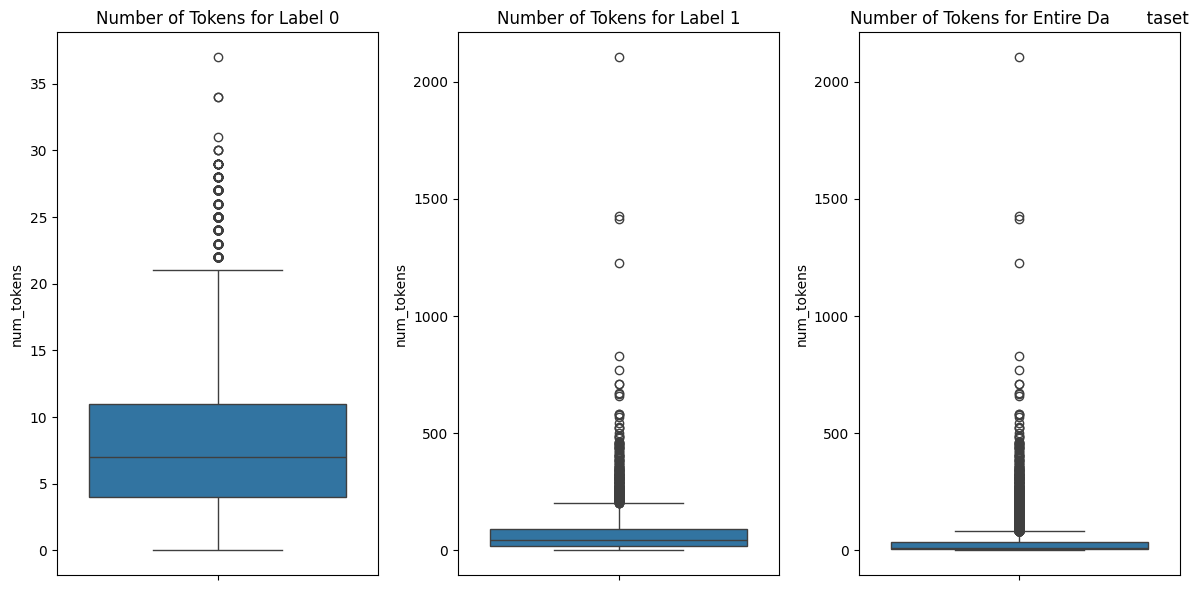

In [41]:
# Making new dataframe to add the tokens and number of tokens to it
new_df = df.copy()

# Apply preprocessing
new_df['tokens'] = new_df['tweet'].map(preprocess_data)
new_df['num_tokens'] = new_df['tokens'].map(len)

# Print min, max, and average values
print("Statistics for Label 0:")
print(f"Min: {new_df[new_df['intention'] == 0]['num_tokens'].min()}")
print(f"Max: {new_df[new_df['intention'] == 0]['num_tokens'].max()}")
print(f"Average: {new_df[new_df['intention'] == 0]['num_tokens'].mean()}")

print("\nStatistics for Label 1:")
print(f"Min: {new_df[new_df['intention'] == 1]['num_tokens'].min()}")
print(f"Max: {new_df[new_df['intention'] == 1]['num_tokens'].max()}")
print(f"Average: {new_df[new_df['intention'] == 1]['num_tokens'].mean()}")

print("\nStatistics for Entire Dataset:")
print(f"Min: {new_df['num_tokens'].min()}")
print(f"Max: {new_df['num_tokens'].max()}")
print(f"Average: {new_df['num_tokens'].mean()}\n")

# Plotting
plt.figure(figsize=(12, 6))

# Box plot for label 0
plt.subplot(1, 3, 1)
sns.boxplot(y=new_df[new_df['intention'] == 0]['num_tokens'])
plt.title('Number of Tokens for Label 0')

# Box plot for label 1
plt.subplot(1, 3, 2)
sns.boxplot(y=new_df[new_df['intention'] == 1]['num_tokens'])
plt.title('Number of Tokens for Label 1')

# Box plot for the entire dataset
plt.subplot(1, 3, 3)
sns.boxplot(y=new_df['num_tokens'])
plt.title('Number of Tokens for Entire Da       taset')

plt.tight_layout()
plt.show()

# Part 1: Constructing Feature Vectors

## Word2Vec - Word Embedding

In [42]:
# printing available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [43]:
W2V_PATH = "word2vec-google-news-300" # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

EMBEDDING_VECTOR_DIM = w2v_model.vector_size

Loading Word2Vec model...
Word2Vec model is loaded.


### What are the methods of dealing with words that are not in the Word2Vec dictionary and name some advantages and disadvantages of each.

**Random Initialization**<br>
_Description_: Assign random vectors to Out-Of-Vocabulary words.<br>
- Advantages:
1. `Simple Implementation`: Easy to implement without any additional training.
2. `Consistency`: Ensures that every word has a corresponding vector, allowing models to process all inputs.
- Disadvantages:
1. `Lack of Semantic Meaning`: Random vectors do not capture the semantic meaning of words.
2. `Potentially Harmful`: Random vectors might confuse the model, leading to poorer performance.

**Zero Vectors**<br>
_Description_: Assign a zero vector to Out-Of-Vocabulary words.
- Advantages:
1. `Simple and Consistent`: Easy to implement and ensures uniform handling of OOV words.
2. `Model Stability`: Zero vectors can prevent the introduction of noise into the model.
- Disadvantages:
1. `No Semantic Information`: Zero vectors carry no information about the word.
2. `Disruption`: Large proportions of zero vectors in the input can disrupt the learning process of neural networks.

**Averaging Known Vectors**<br>
_Description_: Assign the average vector of all known word vectors to OOV words.
- Advantages:
1. `Represents General Meaning`: Provides a general representation of words based on the entire vocabulary.
2. `Improved Semantics`: Better than random vectors or zero vectors in maintaining some level of semantic information.
- Disadvantages:
1. `Overgeneralization`: May not adequately represent specific nuances of individual OOV words.
2. `Computational Cost`: Requires computation of the average vector, which can be costly for large vocabularies.

**Nearest Neighbor Approximation**<br>
_Description_: Use the vector of the nearest known word in the embedding space.
- Advantages:
1. `Semantic Proximity`: Likely to capture similar meaning based on proximity in the embedding space.
2. `Improved Semantic Handling`: Better than random or zero vectors as it leverages the structure of the embedding space.
- Disadvantages:
1. `Dependency on Existing Vectors`: Effectiveness depends on the quality and coverage of the known vectors.
1. `Potential Misrepresentation`: Nearest neighbors might not always be semantically appropriate.

## Dataset

In [44]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size
        self.df_token_col = "tokens"
        self._proc_dataset()
        self.length = len(self.dataframe)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.dataframe.loc[idx, "vector"].transpose(0, 1), self.dataframe.loc[idx, "intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocessing and returning tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # deleting samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        # self.dataframe = self.dataframe.dropna(subset=[self.df_token_col])
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Number of Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Adding padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Geting embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
        self.dataframe = self.dataframe.dropna(subset=["vector"])

    def _get_word_vectors(self, tokens: list):
        # Returning a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
        vectors = []
        try:
            for token in tokens:
                if token in self.w2v_model:
                    vectors.append(self.w2v_model[token])
                else:
                    vectors.append(np.zeros(self.w2v_model.vector_size))
            return self._to_tensor(vectors)
        except:
            return None

    def _pad(self, tokens: list):
        # Adding paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens) > self.max_sequence_len:
            return tokens[:self.max_sequence_len]
        elif len(tokens) < self.max_sequence_len:
            tokens = tokens + (self.max_sequence_len - len(tokens)) * ["<PAD>"]
            return tokens
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        test_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}]")
        print(f":::::All test Tokens:::[{test_tokens:^6}]")
        print(f":::::test Tokens:::[{round(100*test_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

## Split Data into train-test

### Report the division ratio of training and test data and why you use this ratio.

I used 80/20 Split because it's one of the most commonly used splits and provides a good balance between training and evaluation. While it provides a substantial amount of data for training, allowing the model to learn patterns effectively, it ensures enough data is available for testing to get a reliable estimate of the model's performance.

In [45]:
# Spliting dataset into train-test split
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Create Datasets

In [46]:
# creating twitter dataset
train_dataset = Twitter(dataframe=train, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN)
test_dataset = Twitter(dataframe=test, w2v_model=w2v_model, sequence_len=SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Number of Deleted 0-Len Samples: 25
Number of Deleted 0-Len Samples: 8
Train dataset length: 7270
Test dataset length: 1816


In [47]:
train_dataset.seq_report()
test_dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[13876 ]
:::::All test Tokens:::[ 9553 ]
:::::test Tokens:::[68.85%]
Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 6207 ]
:::::All test Tokens:::[ 4847 ]
:::::test Tokens:::[78.09%]


# Part 2: Classification Using CNN

## Model's Network

In [48]:
class CNN(nn.Module):
    def __init__(self, length, k_size, inp_channels, num_labels = 2):
        super(CNN, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv1d(
            in_channels=inp_channels,
            out_channels=64,
            kernel_size=k_size,
            padding=k_size//2
        )
        self.maxpool1 = nn.MaxPool1d(2)

        # Layer 2
        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=k_size,
            padding=k_size//2
        )
        self.maxpool2 = nn.MaxPool1d(2)

        # Layer 3
        self.flatten = nn.Flatten()

        # Layer 4 and 5
        self.fc1 = nn.Linear((length // 4) * 128, 128)
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.flatten(x)

        # Layer 4 and 5
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### What is the effect of kernel size in convolution layers and how is it effective in extracting input features? What does it mean to be more or less?

The kernel size (also known as filter size) in convolution layers refers to the dimensions of the filter used to perform convolution operations on the input data. For a 1D convolution, the kernel size might be a single integer like 3, while for 2D convolutions, it might be a tuple of integers like (3, 3).<br>
Practical Implications:<br>
In NLP tasks, the choice of kernel size affects how the model captures n-grams and patterns in sequences of words or characters. Smaller kernels might focus on local word combinations, while larger kernels might capture phrases or multiple word patterns.<br>
In computer vision, smaller kernels can detect edges and textures, while larger kernels can capture shapes and objects.<br>
Larger kernels capture more contextual and high-level features, increase model complexity and risk of overfitting, and require more computational power.<br>
Smaller kernels focus on local features, reduce the number of parameters, decrease the risk of overfitting, and are computationally more efficient.

### Why didn't we reduce the convolution output and did this reduction through feed forward layers, and what advantages can this layer have over alternative methods?

In designing Convolutional Neural Networks (CNNs) for tasks such as text classification, the choice between reducing the output size through convolutional layers or doing so via feedforward (fully connected) layers has significant implications. Here are some of the reasons:<br>
1. Feature Extraction vs. Classification:<br>
Convolutional layers primarily serve to extract features from the input data. They capture spatial or temporal hierarchies and patterns through a series of transformations.<br>
Fully connected Layer typically handle the task of classification. After features are extracted, these layers map the high-dimensional feature space into the target label space.
2. Preservation of Information:<br>
Convolutional layers reducing the size too aggressively in convolutional layers may result in the loss of important information. Keeping more feature maps through the convolutional stages allows the network to retain richer representations of the input data.<br>
Fully connected layers once a rich set of features is extracted, fully connected layers can reduce the dimensionality in a controlled manner, ensuring that essential information is preserved for the final classification.

_Alternative Methods and Their Comparisons_<br>
- Pooling Layers (MaxPooling, AveragePooling):<br>
Advantages: Pooling layers can reduce the spatial dimensions early on, which decreases the computational load for subsequent layers and helps in making the model more invariant to small translations in the input.<br>
Disadvantages: Pooling can discard valuable information if not used carefully. Aggressive pooling might lead to the loss of important spatial relationships.
- Strided Convolutions:<br>
Advantages: Strided convolutions can downsample the feature maps, integrating feature extraction and dimensionality reduction in a single step. This can lead to simpler network architectures.<br>
Disadvantages: Similar to pooling, strided convolutions may discard important details if the stride is too large.

In [49]:
def model_eval(model, loader, loss_function):
    test_loss = 0
    test_correct = 0
    total_samples = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            # moveing model's inputs to `device`
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # using model's forward pass to generate outputs
            pred = model(inputs)

            # calculating model's loss
            loss = loss_function(pred, labels)
            test_loss += loss.item() * inputs.size(0)

            # calculateing/updating model's accuracy
            _, predicted = torch.max(pred, 1)
            test_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            inputs = inputs.to("cpu")
            labels = labels.to("cpu")

    model.train()

    test_loss /= total_samples
    test_acc = test_correct / total_samples

    return test_loss, test_acc


## Training Model

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(length = SEQUENCE_LEN, k_size = 3, inp_channels = EMBEDDING_VECTOR_DIM).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accs = []
test_losses = []
test_accs = []

# creating dataloaders from datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        # moving model's inputs and outputs to cuda
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # using model's forward pass to generate outputs
        pred = model(inputs)
        loss = loss_function(pred, labels)

        # 1. clearing optimizer's state and zero prev grads
        optimizer.zero_grad()

        # 2. backwarding calculated loss
        loss.backward()

        # 3. steping optimizer
        optimizer.step()

        inputs = inputs.to("cpu")
        labels = labels.to("cpu")


    train_loss, train_acc = model_eval(
        model=model,
        loader=train_loader,
        loss_function=loss_function,
        )
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss, test_acc = model_eval(
        model=model,
        loader=test_loader,
        loss_function=loss_function,
        )
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Printing epoch statistics
    print(f"\nEpoch [{epoch + 1}/{EPOCHS}] Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

history = {
    "train_loss": train_losses,
    "train_acc": train_accs,

    "test_loss": test_losses,
    "test_acc": test_accs,
}

100%|██████████| 114/114 [00:01<00:00, 98.99it/s] 



Epoch [1/15] Training Loss: 0.2933 Training Accuracy: 0.8730
Test Loss: 0.2878 Test Accuracy: 0.8794


100%|██████████| 114/114 [00:01<00:00, 106.10it/s]



Epoch [2/15] Training Loss: 0.2093 Training Accuracy: 0.9050
Test Loss: 0.2356 Test Accuracy: 0.9003


100%|██████████| 114/114 [00:01<00:00, 92.20it/s]



Epoch [3/15] Training Loss: 0.1553 Training Accuracy: 0.9343
Test Loss: 0.2138 Test Accuracy: 0.9113


100%|██████████| 114/114 [00:01<00:00, 88.72it/s] 



Epoch [4/15] Training Loss: 0.1266 Training Accuracy: 0.9547
Test Loss: 0.2242 Test Accuracy: 0.9086


100%|██████████| 114/114 [00:01<00:00, 106.29it/s]



Epoch [5/15] Training Loss: 0.0878 Training Accuracy: 0.9747
Test Loss: 0.2165 Test Accuracy: 0.9163


100%|██████████| 114/114 [00:01<00:00, 106.82it/s]



Epoch [6/15] Training Loss: 0.0577 Training Accuracy: 0.9856
Test Loss: 0.2391 Test Accuracy: 0.9152


100%|██████████| 114/114 [00:01<00:00, 106.19it/s]



Epoch [7/15] Training Loss: 0.0411 Training Accuracy: 0.9905
Test Loss: 0.2615 Test Accuracy: 0.9119


100%|██████████| 114/114 [00:01<00:00, 106.26it/s]



Epoch [8/15] Training Loss: 0.0287 Training Accuracy: 0.9923
Test Loss: 0.2946 Test Accuracy: 0.9069


100%|██████████| 114/114 [00:01<00:00, 86.99it/s]



Epoch [9/15] Training Loss: 0.0216 Training Accuracy: 0.9948
Test Loss: 0.3181 Test Accuracy: 0.9124


100%|██████████| 114/114 [00:01<00:00, 93.63it/s] 



Epoch [10/15] Training Loss: 0.0175 Training Accuracy: 0.9956
Test Loss: 0.3521 Test Accuracy: 0.9108


100%|██████████| 114/114 [00:01<00:00, 106.65it/s]



Epoch [11/15] Training Loss: 0.0159 Training Accuracy: 0.9957
Test Loss: 0.3910 Test Accuracy: 0.9119


100%|██████████| 114/114 [00:01<00:00, 105.76it/s]



Epoch [12/15] Training Loss: 0.0151 Training Accuracy: 0.9960
Test Loss: 0.4135 Test Accuracy: 0.9113


100%|██████████| 114/114 [00:01<00:00, 106.35it/s]



Epoch [13/15] Training Loss: 0.0146 Training Accuracy: 0.9963
Test Loss: 0.4330 Test Accuracy: 0.9119


100%|██████████| 114/114 [00:01<00:00, 107.07it/s]



Epoch [14/15] Training Loss: 0.0146 Training Accuracy: 0.9960
Test Loss: 0.4460 Test Accuracy: 0.9086


100%|██████████| 114/114 [00:01<00:00, 82.85it/s]



Epoch [15/15] Training Loss: 0.0137 Training Accuracy: 0.9964
Test Loss: 0.4345 Test Accuracy: 0.9080


### Briefly explain how the SGD optimizer works and how it differs from the Adam optimizer.

**SGD**<br>
Stochastic Gradient Descent (SGD) is a variant of the Gradient Descent optimization algorithm used to minimize a loss function in machine learning models. Instead of computing the gradient of the loss function using the entire dataset (as in Batch Gradient Descent), SGD updates the model parameters using the gradient computed from a randomly selected subset of the data, often just a single data point.<br>
**Adam**<br>
Adam (short for Adaptive Moment Estimation) is an optimization algorithm that combines the advantages of two other extensions of SGD: AdaGrad and RMSProp. It computes adaptive learning rates for each parameter by maintaining running averages of both the gradients and the squared gradients.<br>
_Difference:_<br>
SGD is simpler and computationally efficient but it can be noisy and unstable. Adam, on the other hand, offers adaptive learning rates and typically more stable and faster convergence, though it is computationally more complex.

### Explain the reason for using the Cross Entropy cost function according to the nature of the problem.

The Cross Entropy (or Log Loss) cost function is commonly used in binary and multi-class classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1.

**Reasons for Using Cross Entropy**
1. Probabilistic Interpretation:<br>
Cross Entropy is well-suited for models that output probabilities. In the context of classifying tweets, the model outputs the probability that a tweet belongs to the "suicidal" class. Cross Entropy directly measures how well the predicted probability distribution aligns with the actual distribution of the data.
2. Penalizing Confident but Wrong Predictions:<br>
Cross Entropy penalizes predictions that are both wrong and confident more heavily. For instance, if the model is very confident (e.g., predicts a probability close to 1) that a non-suicidal tweet is suicidal, the loss will be very high. This helps the model learn not to make such confident errors.

3. Gradient-Based Optimization:<br>
The Cross Entropy loss function works well with gradient descent optimization methods. It provides smooth gradients that help in efficiently updating the model's parameters during training, leading to faster and more reliable convergence.

4. Interpretability and Calibration:<br>
The probabilities produced by a model trained with Cross Entropy are typically well-calibrated, meaning the predicted probabilities reflect the actual likelihood of the classes. This is particularly important in sensitive applications like detecting suicidal tweets, where understanding the confidence of the model's predictions can be crucial.

5. Handling Imbalanced Data:<br>
In many real-world scenarios, including the classification of suicidal tweets, the dataset can be imbalanced (e.g., there are fewer suicidal tweets than non-suicidal ones). Cross Entropy loss, especially when combined with techniques like class weighting, can help the model handle such imbalance more effectively.

### Impact of hypermeters

**Learning Rate:**<br>
- Effect: The learning rate determines the size of the steps taken during the optimization process (e.g., gradient descent) to update the model parameters.
- Impact:
 1. Too high a learning rate can cause the optimization process to diverge, leading to unstable training and potentially poor convergence.
 2. Too low a learning rate can result in slow convergence or getting stuck in local minima.
 3. An appropriate learning rate is essential for achieving faster convergence and better generalization.

**Batch Size:**<br>
- Effect: Batch size determines the number of samples processed before updating the model parameters during training.
- Impact:
 1. A larger batch size can result in more stable gradients and faster convergence because it provides more accurate estimates of the gradient direction.
 2. However, larger batch sizes require more memory, which can limit the size of the model or the size of the dataset that can fit into memory.
 3. Smaller batch sizes might result in noisier gradient estimates but can sometimes help the model generalize better.

**Number of Epochs:**<br>
- Effect: An epoch is one complete pass through the entire dataset during training.
- Impact:
 1. Training for too few epochs might result in underfitting, where the model hasn't learned enough from the data.
 2. Training for too many epochs can lead to overfitting, where the model learns the training data too well but fails to generalize to unseen data.
 3. The appropriate number of epochs depends on factors such as the complexity of the model, the size of the dataset, and the learning rate.

In [51]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [52]:
def generate_confusion_matrix(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    labels = []
    predictions = []
    with torch.no_grad():
        for inputs, labls in loader:
            # Move inputs and labels to the specified device
            inputs = inputs.to(device = device)
            labls =  labls.to(device = device)

            # Forward pass to get model's predictions
            outputs = model(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)

            # Collect all true labels and predictions
            labels.extend(labls.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())

        cm = metrics.confusion_matrix(y_true=labels, y_pred=predictions)
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
        plt.xlabel('Predicted Label', labelpad=20)
        plt.ylabel('True Label', labelpad=20)
        plt.title('Confusion Matrix', fontsize=20)

        recall = metrics.recall_score(y_true=labels, y_pred=predictions, average='macro')
        f1 = metrics.f1_score(y_true=labels, y_pred=predictions, average='macro')
        precision = metrics.precision_score(y_true=labels, y_pred=predictions, average='macro')
        report = metrics.classification_report(y_true=labels, y_pred=predictions)

        return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


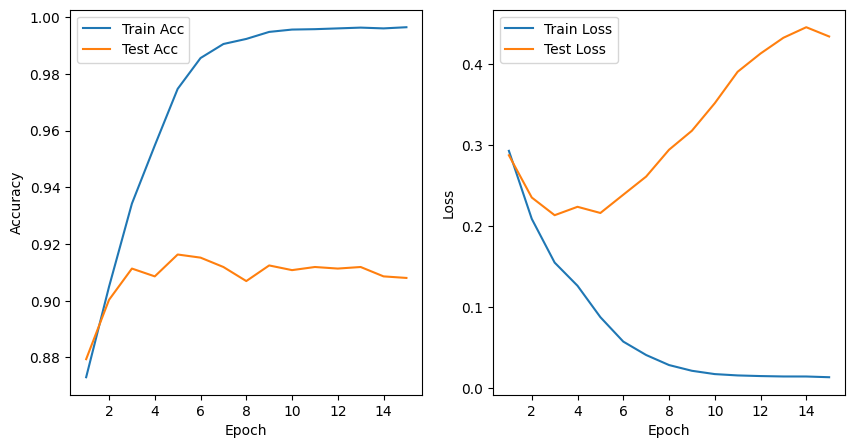

In [53]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history["train_acc"]),
            ("Test Acc", history["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", history["train_loss"]),
            ("Test Loss", history["test_loss"])
        ]
    }
)

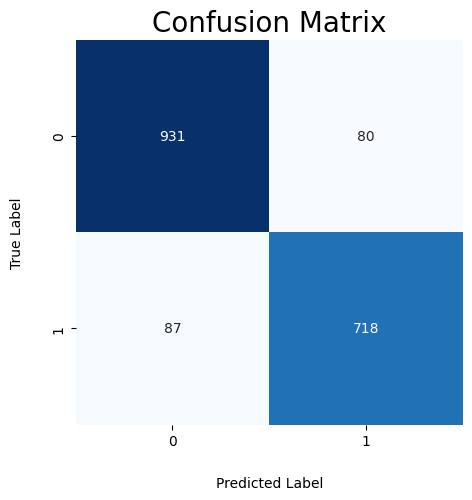

In [54]:
model_report = generate_confusion_matrix(model=model, loader=test_loader)

In [55]:
print(f"Recall:    {model_report['recall']:.3f}")
print(f"F1:        {model_report['f1']:.3f}")
print(f"Precision: {model_report['precision']:.3f}")
print(model_report['report'])

Recall:    0.906
F1:        0.907
Precision: 0.907
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1011
           1       0.90      0.89      0.90       805

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816



# Part 3: Effect of Context Window in Model Traing

### In a convolutional neural network, what advantages and disadvantages can increasing the size of the context window(so that it is more than all the sentences in the dataset) have?

Advantages:<br>
1. `Global Contextual Information`: A larger context window allows the model to capture more global contextual information from the input text. This can be beneficial for tasks where understanding the entire document or a larger context is crucial, such as document classification or sentiment analysis.

2. `Long-range Dependencies`: With a larger context window, the model can capture long-range dependencies between words or tokens in the input text. This is particularly useful for tasks where understanding the relationships between distant words or entities is important, such as in question answering or document summarization.

3. `Improved Representation Learning`: By considering a wider context, the model may learn more robust and informative representations of the input text, which can lead to better generalization and performance on downstream tasks.

Disadvantages:<br>
1. `Increased Computational Complexity`: As the size of the context window increases, the computational complexity of the CNN also increases. Processing a larger context window requires more memory and computational resources, which can make training and inference slower and more resource-intensive.

2. `Potential Information Overload`: Including too much irrelevant context in the input can introduce noise and make it more challenging for the model to focus on relevant information. This can lead to decreased performance, especially if the dataset contains a lot of noise or irrelevant information.

3. `Difficulty in Learning Local Patterns`: With a larger context window, the model may focus more on capturing global patterns and context, potentially at the expense of learning local patterns and nuances in the input text. This can be detrimental for tasks where understanding local context or semantics is critical.

4. `Risk of Oversmoothing`: A larger context window may lead to oversmoothing of the input text, where fine-grained details and distinctions between different parts of the input are lost. This can result in less discriminative representations and reduced performance on tasks that require capturing subtle differences.

## New model with context window = 196

In [56]:
NEW_SEQUENCE_LEN = 196

In [57]:
train_dataset1 = Twitter(dataframe=train, w2v_model=w2v_model, sequence_len=NEW_SEQUENCE_LEN)
test_dataset1 = Twitter(dataframe=test, w2v_model=w2v_model, sequence_len=NEW_SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset1)}")
print(f"Test dataset length: {len(test_dataset1)}")

Number of Deleted 0-Len Samples: 25
Number of Deleted 0-Len Samples: 8
Train dataset length: 7270
Test dataset length: 1816


In [58]:
train_dataset1.seq_report()
test_dataset1.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 196 ]
:::::MIN  LENGTH:::[ 196 ]
:::::MEAN LENGTH:::[196.0]
Sequence Tokenization Report
:::::All Unique Tokens:::[16865 ]
:::::All test Tokens:::[11059 ]
:::::test Tokens:::[65.57%]
Sequence Length Report
:::::MAX  LENGTH:::[ 196 ]
:::::MIN  LENGTH:::[ 196 ]
:::::MEAN LENGTH:::[196.0]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 7497 ]
:::::All test Tokens:::[ 5661 ]
:::::test Tokens:::[75.51%]


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = CNN(length = NEW_SEQUENCE_LEN, k_size = 3, inp_channels = EMBEDDING_VECTOR_DIM).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)


train_losses1 = []
train_accs1 = []
test_losses1 = []
test_accs1 = []

# creating dataloaders from datasets
train_loader1 = DataLoader(train_dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(test_dataset1, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    for idx, (inputs, labels) in enumerate(tqdm(train_loader1)):
        # moving model's inputs and outputs to cuda
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # using model's forward pass to generate outputs
        pred = model1(inputs)
        loss = loss_function(pred, labels)

        # 1. clearing optimizer's state and zero prev grads
        optimizer1.zero_grad()

        # 2. backwarding calculated loss
        loss.backward()

        # 3. steping optimizer
        optimizer1.step()

        inputs = inputs.to("cpu")
        labels = labels.to("cpu")


    train_loss, train_acc = model_eval(
        model=model1,
        loader=train_loader1,
        loss_function=loss_function,
        )
    train_losses1.append(train_loss)
    train_accs1.append(train_acc)

    test_loss, test_acc = model_eval(
        model=model1,
        loader=test_loader1,
        loss_function=loss_function,
        )
    test_losses1.append(test_loss)
    test_accs1.append(test_acc)

    # Printing epoch statistics
    print(f"\nEpoch [{epoch + 1}/{EPOCHS}] Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

history1 = {
    "train_loss": train_losses1,
    "train_acc": train_accs1,

    "test_loss": test_losses1,
    "test_acc": test_accs1,
}

100%|██████████| 114/114 [00:02<00:00, 41.85it/s]



Epoch [1/15] Training Loss: 0.2927 Training Accuracy: 0.8758
Test Loss: 0.2867 Test Accuracy: 0.8767


100%|██████████| 114/114 [00:02<00:00, 46.80it/s]



Epoch [2/15] Training Loss: 0.2067 Training Accuracy: 0.9116
Test Loss: 0.2303 Test Accuracy: 0.9014


100%|██████████| 114/114 [00:02<00:00, 46.07it/s]



Epoch [3/15] Training Loss: 0.1698 Training Accuracy: 0.9316
Test Loss: 0.2201 Test Accuracy: 0.9086


100%|██████████| 114/114 [00:02<00:00, 46.35it/s]



Epoch [4/15] Training Loss: 0.1483 Training Accuracy: 0.9345
Test Loss: 0.2349 Test Accuracy: 0.9080


100%|██████████| 114/114 [00:03<00:00, 36.56it/s]



Epoch [5/15] Training Loss: 0.1142 Training Accuracy: 0.9542
Test Loss: 0.2342 Test Accuracy: 0.9130


100%|██████████| 114/114 [00:02<00:00, 46.41it/s]



Epoch [6/15] Training Loss: 0.0852 Training Accuracy: 0.9737
Test Loss: 0.2318 Test Accuracy: 0.9064


100%|██████████| 114/114 [00:02<00:00, 45.15it/s]



Epoch [7/15] Training Loss: 0.0591 Training Accuracy: 0.9828
Test Loss: 0.2731 Test Accuracy: 0.9064


100%|██████████| 114/114 [00:02<00:00, 46.38it/s]



Epoch [8/15] Training Loss: 0.0464 Training Accuracy: 0.9876
Test Loss: 0.2986 Test Accuracy: 0.8965


100%|██████████| 114/114 [00:02<00:00, 47.11it/s]



Epoch [9/15] Training Loss: 0.0284 Training Accuracy: 0.9933
Test Loss: 0.3031 Test Accuracy: 0.9157


100%|██████████| 114/114 [00:03<00:00, 37.45it/s]



Epoch [10/15] Training Loss: 0.0213 Training Accuracy: 0.9950
Test Loss: 0.3233 Test Accuracy: 0.9069


100%|██████████| 114/114 [00:02<00:00, 46.62it/s]



Epoch [11/15] Training Loss: 0.0232 Training Accuracy: 0.9937
Test Loss: 0.4060 Test Accuracy: 0.9080


100%|██████████| 114/114 [00:02<00:00, 43.90it/s]



Epoch [12/15] Training Loss: 0.0151 Training Accuracy: 0.9957
Test Loss: 0.3754 Test Accuracy: 0.9097


100%|██████████| 114/114 [00:02<00:00, 47.32it/s]



Epoch [13/15] Training Loss: 0.0153 Training Accuracy: 0.9959
Test Loss: 0.4223 Test Accuracy: 0.9135


100%|██████████| 114/114 [00:02<00:00, 46.73it/s]



Epoch [14/15] Training Loss: 0.0155 Training Accuracy: 0.9957
Test Loss: 0.4476 Test Accuracy: 0.9080


100%|██████████| 114/114 [00:02<00:00, 39.35it/s]



Epoch [15/15] Training Loss: 0.0223 Training Accuracy: 0.9953
Test Loss: 0.4747 Test Accuracy: 0.9080


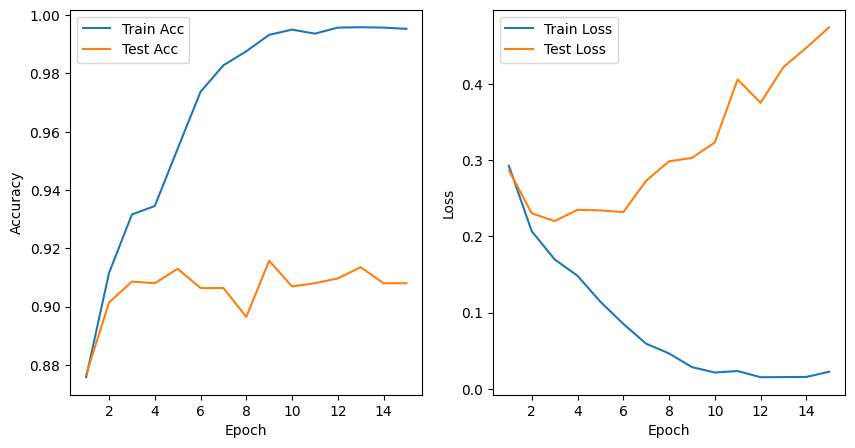

In [60]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history1["train_acc"]),
            ("Test Acc", history1["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", history1["train_loss"]),
            ("Test Loss", history1["test_loss"])
        ]
    }
)

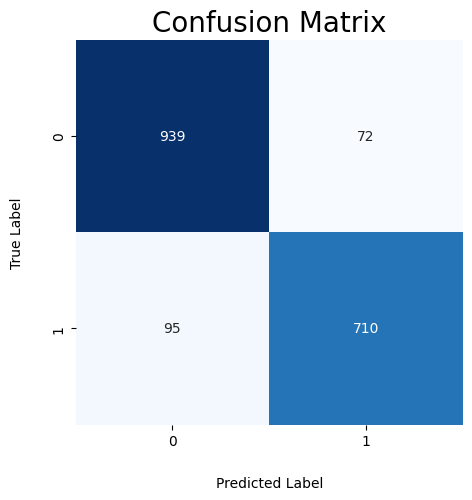

In [61]:
model_report1 = generate_confusion_matrix(model=model1, loader=test_loader1)

In [62]:
print(f"Recall:    {model_report1['recall']:.3f}")
print(f"F1:        {model_report1['f1']:.3f}")
print(f"Precision: {model_report1['precision']:.3f}")
print(model_report1['report'])

Recall:    0.905
F1:        0.907
Precision: 0.908
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1011
           1       0.91      0.88      0.89       805

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816



# Part 4: Effect of Regularization Methods in Training Methods

## New model with Dropout and Batch Normalization Layers

In [72]:
class CNN2(nn.Module):
    def __init__(self, length, k_size, inp_channels, num_labels = 2):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=inp_channels,
            out_channels=64,
            kernel_size=k_size,
            padding=k_size//2
        )
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.5)
        self.maxpool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=128,
            kernel_size=k_size,
            padding=k_size//2
        )
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.maxpool2 = nn.MaxPool1d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((length // 4) * 128, 128)
        self.fc2 = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = CNN2(length = SEQUENCE_LEN, k_size = 3, inp_channels = EMBEDDING_VECTOR_DIM).to(device)

optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

train_losses2 = []
train_accs2 = []
test_losses2 = []
test_accs2 = []

for epoch in range(EPOCHS):
    for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        # moving model's inputs and outputs to cuda
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # using model's forward pass to generate outputs
        pred = model2(inputs)
        loss = loss_function(pred, labels)

        # 1. clearing optimizer's state and zero prev grads
        optimizer2.zero_grad()

        # 2. backwarding calculated loss
        loss.backward()

        # 3. steping optimizer
        optimizer2.step()

        inputs = inputs.to("cpu")
        labels = labels.to("cpu")


    train_loss, train_acc = model_eval(
        model=model2,
        loader=train_loader,
        loss_function=loss_function,
        )
    train_losses2.append(train_loss)
    train_accs2.append(train_acc)

    test_loss, test_acc = model_eval(
        model=model2,
        loader=test_loader,
        loss_function=loss_function,
        )
    test_losses2.append(test_loss)
    test_accs2.append(test_acc)

    # Printing epoch statistics
    print(f"\nEpoch [{epoch + 1}/{EPOCHS}] Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

history2 = {
    "train_loss": train_losses2,
    "train_acc": train_accs2,

    "test_loss": test_losses2,
    "test_acc": test_accs2,
}

100%|██████████| 114/114 [00:01<00:00, 98.28it/s]



Epoch [1/15] Training Loss: 0.2449 Training Accuracy: 0.9063
Test Loss: 0.2602 Test Accuracy: 0.8937


100%|██████████| 114/114 [00:01<00:00, 102.35it/s]



Epoch [2/15] Training Loss: 0.2161 Training Accuracy: 0.9304
Test Loss: 0.2469 Test Accuracy: 0.9047


100%|██████████| 114/114 [00:01<00:00, 83.00it/s]



Epoch [3/15] Training Loss: 0.1689 Training Accuracy: 0.9494
Test Loss: 0.2183 Test Accuracy: 0.9097


100%|██████████| 114/114 [00:01<00:00, 97.93it/s] 



Epoch [4/15] Training Loss: 0.1461 Training Accuracy: 0.9527
Test Loss: 0.2089 Test Accuracy: 0.9174


100%|██████████| 114/114 [00:01<00:00, 102.54it/s]



Epoch [5/15] Training Loss: 0.1465 Training Accuracy: 0.9620
Test Loss: 0.2226 Test Accuracy: 0.8970


100%|██████████| 114/114 [00:01<00:00, 101.97it/s]



Epoch [6/15] Training Loss: 0.1133 Training Accuracy: 0.9696
Test Loss: 0.2027 Test Accuracy: 0.9157


100%|██████████| 114/114 [00:01<00:00, 101.55it/s]



Epoch [7/15] Training Loss: 0.1111 Training Accuracy: 0.9696
Test Loss: 0.2229 Test Accuracy: 0.9036


100%|██████████| 114/114 [00:01<00:00, 102.07it/s]



Epoch [8/15] Training Loss: 0.0958 Training Accuracy: 0.9783
Test Loss: 0.2089 Test Accuracy: 0.9180


100%|██████████| 114/114 [00:01<00:00, 76.19it/s]



Epoch [9/15] Training Loss: 0.0895 Training Accuracy: 0.9805
Test Loss: 0.2124 Test Accuracy: 0.9191


100%|██████████| 114/114 [00:01<00:00, 102.18it/s]



Epoch [10/15] Training Loss: 0.0637 Training Accuracy: 0.9849
Test Loss: 0.2190 Test Accuracy: 0.9141


100%|██████████| 114/114 [00:01<00:00, 103.00it/s]



Epoch [11/15] Training Loss: 0.0666 Training Accuracy: 0.9862
Test Loss: 0.2162 Test Accuracy: 0.9124


100%|██████████| 114/114 [00:01<00:00, 101.90it/s]



Epoch [12/15] Training Loss: 0.0697 Training Accuracy: 0.9836
Test Loss: 0.2339 Test Accuracy: 0.9036


100%|██████████| 114/114 [00:01<00:00, 102.39it/s]



Epoch [13/15] Training Loss: 0.0521 Training Accuracy: 0.9900
Test Loss: 0.2185 Test Accuracy: 0.9202


100%|██████████| 114/114 [00:01<00:00, 93.59it/s]



Epoch [14/15] Training Loss: 0.0459 Training Accuracy: 0.9902
Test Loss: 0.2337 Test Accuracy: 0.9157


100%|██████████| 114/114 [00:01<00:00, 82.36it/s]



Epoch [15/15] Training Loss: 0.0453 Training Accuracy: 0.9900
Test Loss: 0.2374 Test Accuracy: 0.9124


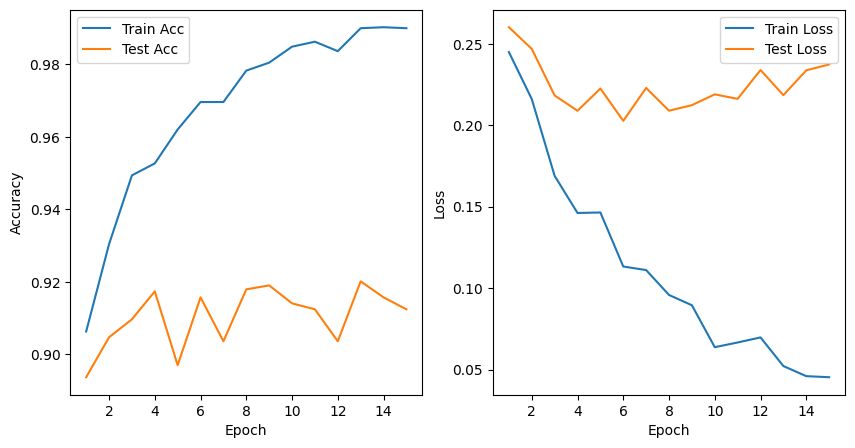

In [74]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history2["train_acc"]),
            ("Test Acc", history2["test_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", history2["train_loss"]),
            ("Test Loss", history2["test_loss"])
        ]
    }
)

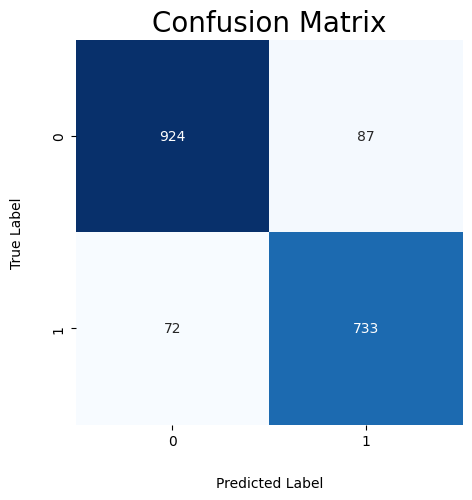

In [75]:
model_report2 = generate_confusion_matrix(model=model2, loader=test_loader)

In [76]:
print(f"Recall:    {model_report2['recall']:.3f}")
print(f"F1:        {model_report2['f1']:.3f}")
print(f"Precision: {model_report2['precision']:.3f}")
print(model_report2['report'])

Recall:    0.912
F1:        0.911
Precision: 0.911
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1011
           1       0.89      0.91      0.90       805

    accuracy                           0.91      1816
   macro avg       0.91      0.91      0.91      1816
weighted avg       0.91      0.91      0.91      1816

